# TASK 3 - Shipping Time Prediction

In the present notebook, a shipping time analysis to predict an accurate date of delivery is done, in order to improve the quality of the shipping service.

The first thing to do is to import the libraries that the code will need to run.

In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import geopy.distance
import math
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from sklearn.linear_model import PoissonRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import tensorflow as tf
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras import Model

In order to have as much information as possible about single orders so that significant features could be selected to predict the shipping time, different datasets had to be merged to combine their data.
This process is what the following cell contains. In particular data about sellers, customers, cities and order status were put together and some useful variables were created. Some of them are:
- 'shipping_time' which will be our dependent variable and is given by the difference in days between the purchase date and the delivery date.
- 'orders_per_day' which is the number of orders that each seller receives per day.
- 'media_deltatime' which is the average time it takes for a product bought by a certain seller to be delivered. This can be considered as a measure of the seller's "speed".
- 'prod_volume' computed by multiplying the products' 3 dimensions (height, lenght, width).

You can directly go to the 'task3' folder in the GitHub repository to download the resulting dataframe ('task3.csv') and run the code!

In [11]:
sellers = pd.read_csv('sellers.csv', sep = ',', encoding = "utf-8")
sellers = sellers.drop(['Unnamed: 0'], axis = 1)
sellers.rename(columns = {'seller_city':'city'}, inplace = True)

geo = pd.read_csv('01.geo.csv', sep = ';', encoding = "ISO-8859-1")
geo.rename(columns = {'geo_city':'city'}, inplace = True)

df_customers = pd.read_csv('02.customers.csv', sep=";", encoding = 'unicode_escape')
df_sellers = pd.read_csv('03.sellers.csv', sep=";", encoding = 'unicode_escape')
df_orderstatus = pd.read_csv('04.order_status.csv', sep=";", encoding = 'unicode_escape')
df_orderitems = pd.read_csv('05.order_items.csv', sep=";", encoding = 'unicode_escape')
df_products = pd.read_csv('08.products.csv', sep=";", encoding = 'unicode_escape')

task3 = pd.merge(df_orderstatus, df_orderitems , on = 'order_id', how = 'left')
task3 = task3.dropna()
task3 = pd.merge(task3, df_sellers , on = 'seller_id', how = 'left')
task3 = pd.merge(task3, sellers , on = 'seller_id', how = 'left')
task3 = task3.drop(['order_status', 'seller_autonomous_community_x', 'seller_city'], axis=1)
task3 = pd.merge(task3, geo , on = 'city', how = 'left')
task3.rename(columns = {'city':'seller_city',
                        'geo_latitude':'seller_city_lat',
                        'geo_longitude':'seller_city_long'}, inplace = True)
task3 = task3.drop(['geo_admin1_code', 'geo_autonomous_community'], axis=1)

task3 = task3.dropna()
df_customers.rename(columns = {'customer_city': 'city'}, inplace = True)
df_customers = pd.merge(df_customers, geo, on = 'city', how = 'left')
df_customers = df_customers.drop(['geo_admin1_code', 'geo_autonomous_community'], axis=1)

df_customers.rename(columns = {'city':'customer_city',
                        'geo_latitude':'customer_city_lat',
                        'geo_longitude':'customer_city_long'}, inplace = True)

task3 = pd.merge(task3, df_customers, on = 'customer_id', how = 'left')
task3 = task3.dropna()


def distancer(row):
    coords_1 = (row['customer_city_lat'], row['customer_city_long'])
    coords_2 = (row['seller_city_lat'], row['seller_city_long'])
    return geopy.distance.geodesic(coords_1, coords_2).km

task3['distance'] = task3.apply (lambda row: distancer (row),axis=1)

task3 = pd.merge(task3, df_products, on = 'product_id', how = 'left')

task3['ts_order_purchase'] = task3['ts_order_purchase'].str[:10]
task3['ts_order_approved'] = task3['ts_order_approved'].str[:10]
task3['ts_order_delivered_carrier'] = task3['ts_order_delivered_carrier'].str[:10]
task3['ts_order_delivered_customer'] = task3['ts_order_delivered_customer'].str[:10]
task3['ts_order_estimated_delivery'] = task3['ts_order_estimated_delivery'].str[:10]

task3['ts_order_purchase'] = pd.to_datetime(task3['ts_order_purchase'], dayfirst = True)
task3['ts_order_approved'] = pd.to_datetime(task3['ts_order_approved'], dayfirst = True)
task3['ts_order_delivered_carrier'] = pd.to_datetime(task3['ts_order_delivered_carrier'], dayfirst = True)
task3['ts_order_delivered_customer'] = pd.to_datetime(task3['ts_order_delivered_customer'], dayfirst = True)
task3['ts_order_estimated_delivery'] = pd.to_datetime(task3['ts_order_estimated_delivery'], dayfirst = True)

task3['shipping_time'] = (task3['ts_order_delivered_customer'] - task3['ts_order_purchase']).dt.days
task3['num_order_carrier'] = task3['ts_order_delivered_carrier'].map(task3['ts_order_delivered_carrier'].value_counts())
task3['prod_volume'] = (task3['product_length_cm']*task3['product_height_cm']*task3['product_width_cm'])
task3['estimated_delivery_time'] = (task3['ts_order_estimated_delivery'] - task3['ts_order_purchase']).dt.days
task3['orders_per_day'] = task3.groupby(['ts_order_purchase', 'seller_id'])['ts_order_purchase'].transform('count')

Before any prediction task, it is important to do an exploratory data analysis to detect insightful patterns in the data that could also be helpful for the analysis.

Let's first look at the distribution of our dependent variable 'shipping_time'.

<AxesSubplot:xlabel='shipping_time', ylabel='Count'>

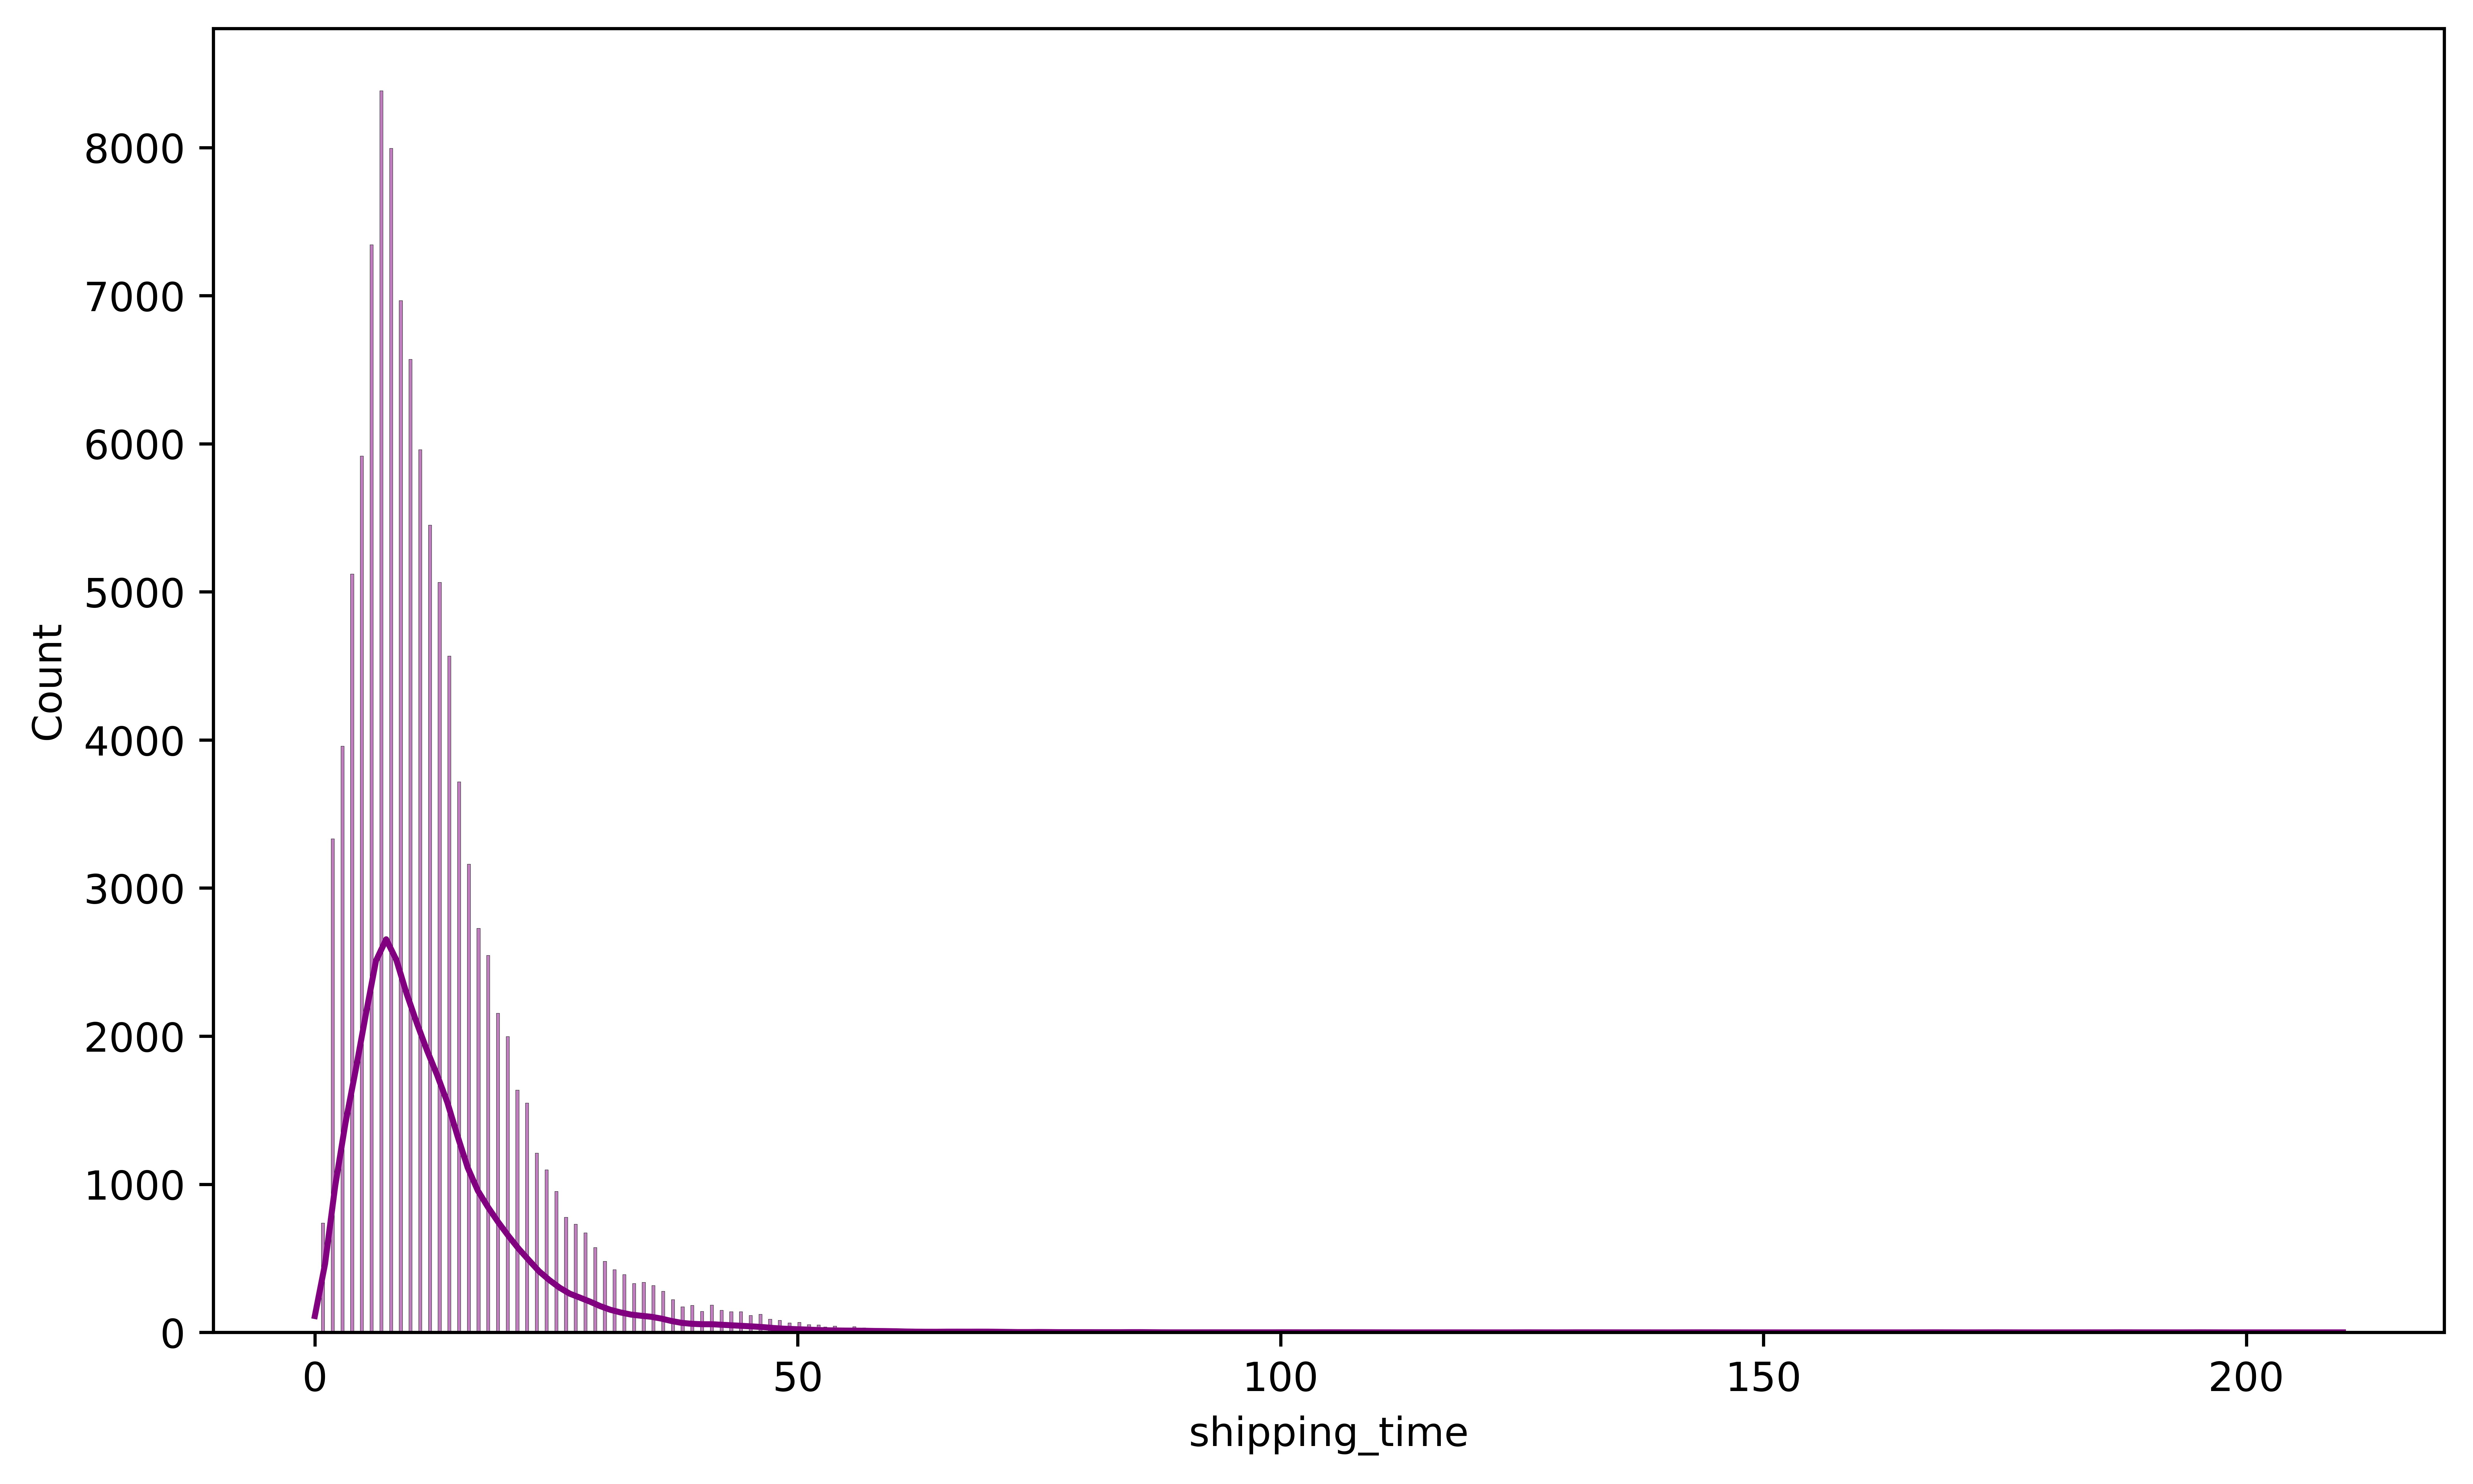

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(data = task3, x = "shipping_time", kde=True, color = "purple")
#plt.rcParams['figure.dpi'] = 1000

As it can be seen, the distribution is right-skewed and it shows that most of the orders take between 1 to 50 days to arrive to customers. 
This implies the presence of outliers, as it is shown in the following boxplot.

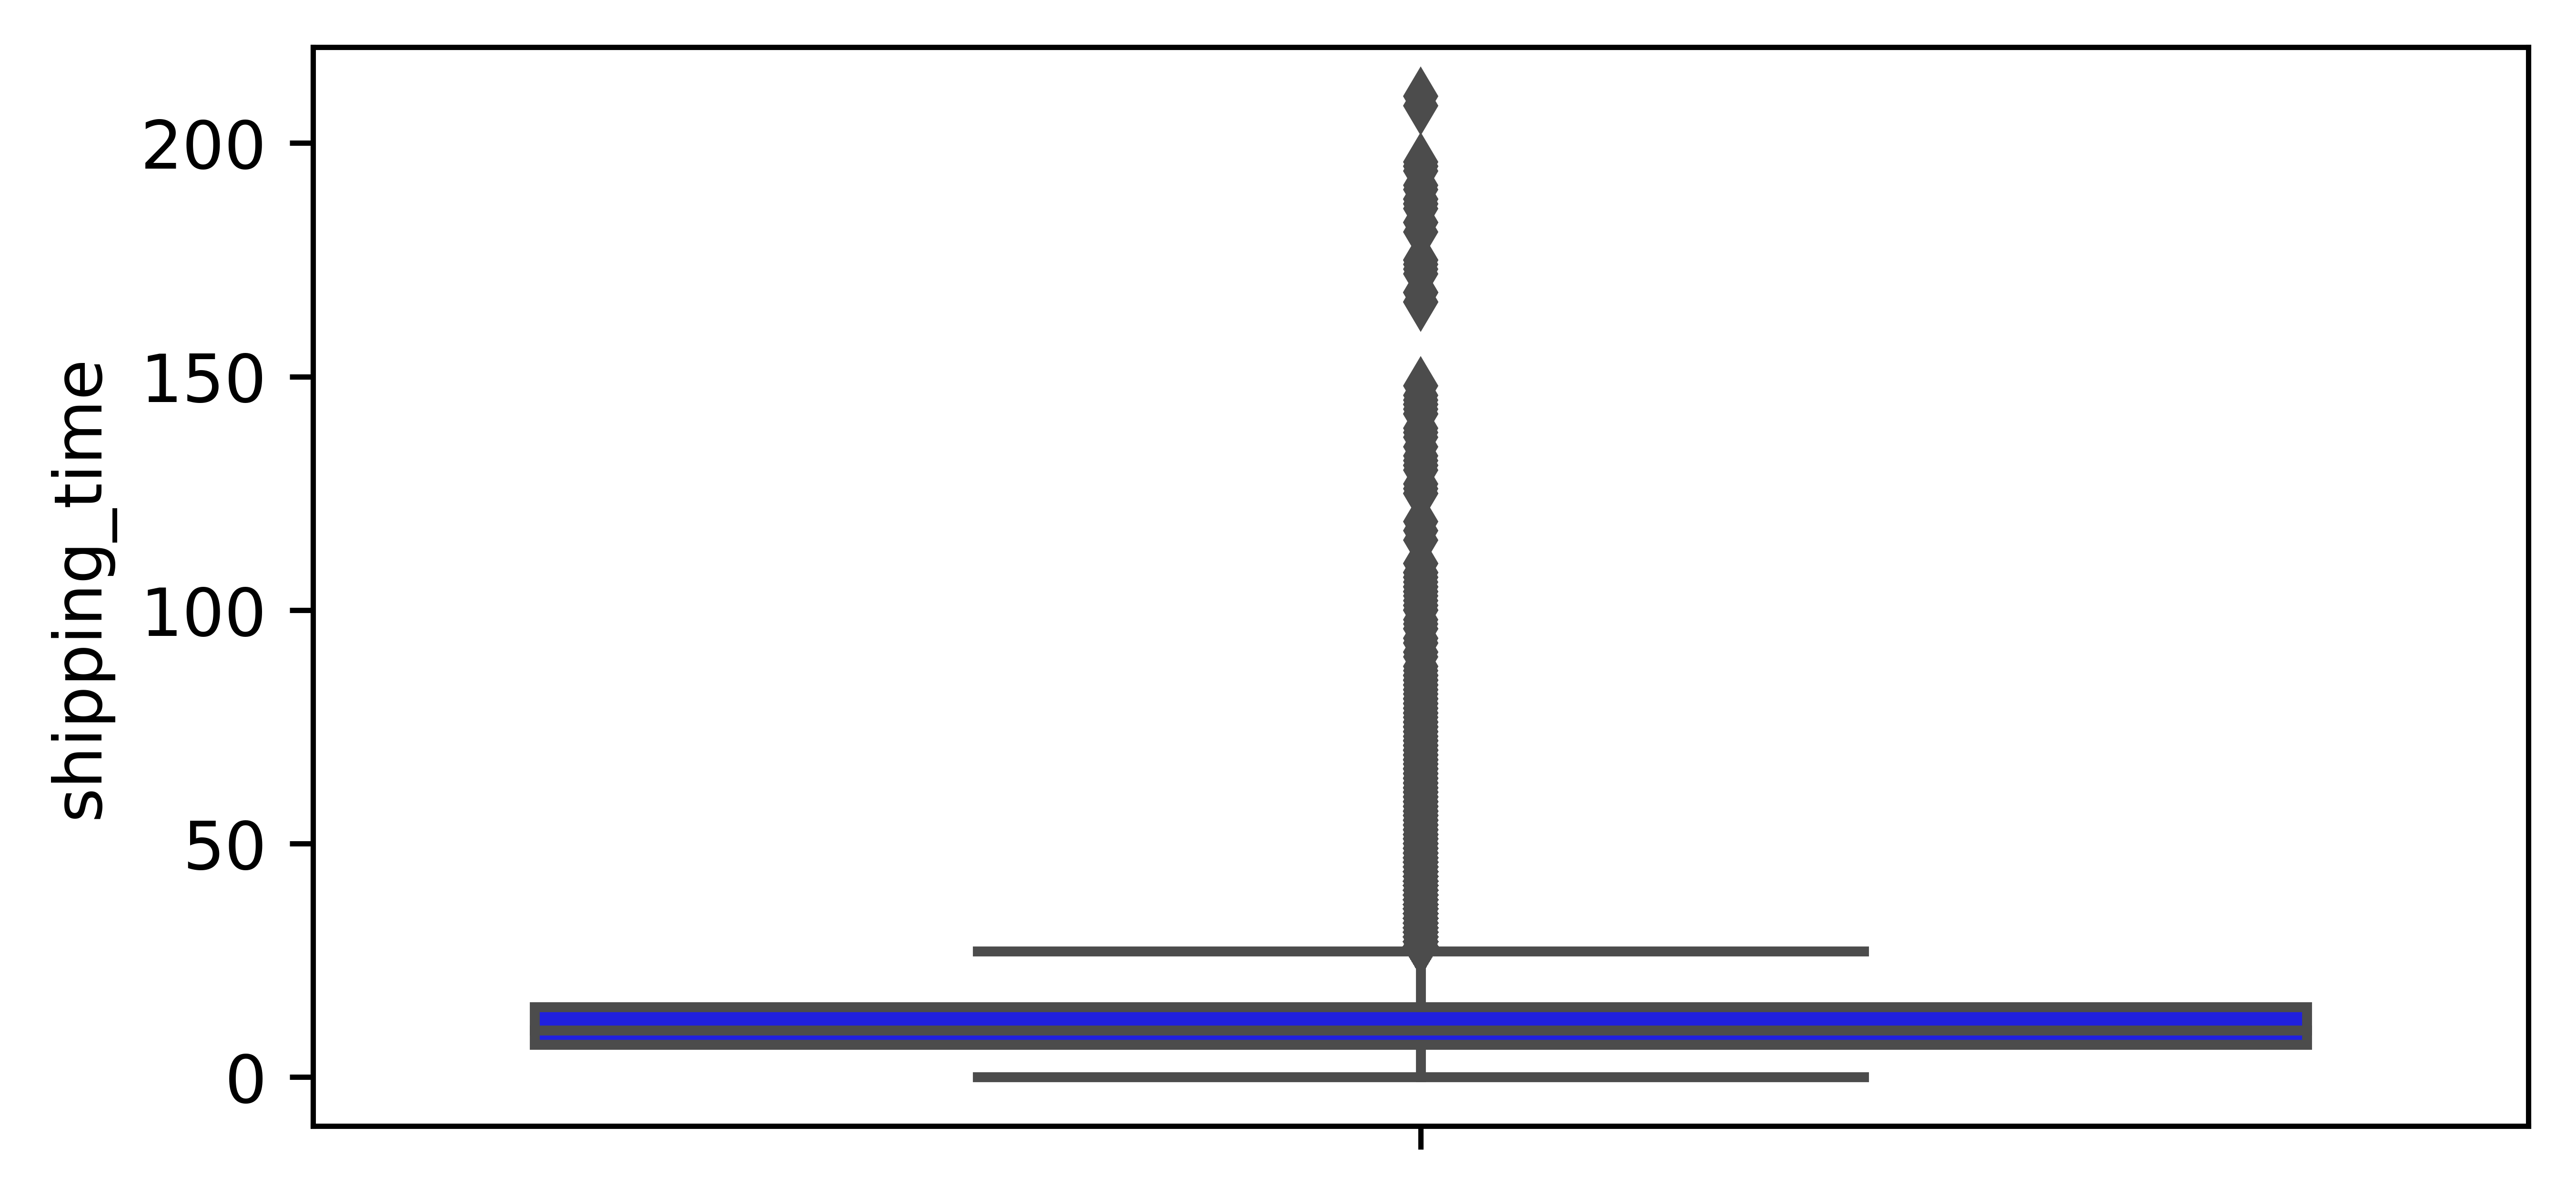

In [13]:
plt.figure(figsize=(6, 3))
sns.boxplot(y=task3["shipping_time"], color = 'blue')
plt.rcParams['figure.dpi'] = 500

Outliers increase the variability in the data, which decreases models' predictive performance. Therefore, since they're just "exceptions" probably due to unforeseeable factors that influenced the shipping time, they are deleted from the dataset.

In [14]:
#removing outliers
Q1 = task3['shipping_time'].quantile(0.25)
Q3 = task3['shipping_time'].quantile(0.75)
task3 = task3.loc[(task3['shipping_time'] > Q1) & (task3['shipping_time'] < Q3)]

In [15]:
task3.to_csv('task3.csv')

The following cell shows how the resulting dataset looks like. It has 83721 rows and 41 columns.

In [16]:
task3 = pd.read_csv('task3.csv', low_memory=False)
task3 = task3.drop('Unnamed: 0', axis=1)
task3

,order_id,customer_id,ts_order_purchase,ts_order_approved,ts_order_delivered_carrier,ts_order_delivered_customer,ts_order_estimated_delivery,order_item_sequence_id,product_id,price,...,product_weight_gr,product_length_cm,product_height_cm,product_width_cm,product_photo_quantity,shipping_time,num_order_carrier,prod_volume,estimated_delivery_time,orders_per_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2018-10-02,2018-10-02,2018-10-04,2018-10-10,2018-10-18,1.0,87285b34884572647811a353c7ac498a,"29,99",...,500.0,19.0,8.0,13.0,4.0,8,301,1976.0,16,1
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2019-07-24,2019-07-26,2019-07-26,2019-08-07,2019-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,"118,7",...,400.0,19.0,13.0,19.0,1.0,14,323,4693.0,20,4
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2019-08-08,2019-08-08,2019-08-08,2019-08-17,2019-09-04,1.0,aa4383b373c6aca5d8797843e5594415,"159,9",...,420.0,24.0,19.0,21.0,1.0,9,386,9576.0,27,3
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2018-11-18,2018-11-18,2018-11-22,2018-12-02,2018-12-15,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,45,...,450.0,30.0,10.0,20.0,3.0,14,406,6000.0,27,1
4,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,2018-05-16,2018-05-16,2018-05-22,2018-05-26,2018-06-07,1.0,4520766ec412348b8d4caa5e8a18c464,"59,99",...,50.0,16.0,16.0,17.0,1.0,10,202,4352.0,22,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42572,b0f4af5c1b06e24fef510703bfe9f0a6,8e1ec396e317ff4c82a03ce16a0c3eb3,2018-10-27,2018-10-27,2018-10-30,2018-11-10,2018-11-22,1.0,595fac2a385ac33a80bd5114aec74eb8,"142,5",...,400.0,19.0,13.0,19.0,1.0,14,212,4693.0,26,1
42573,aa04ef5214580b06b10e2a378300db44,f01a6bfcc730456317e4081fe0c9940e,2018-01-27,2018-01-27,2018-01-30,2018-02-07,2018-03-17,1.0,9fc063fd34fed29ccc57b7f8e8d03388,370,...,750.0,38.0,12.0,25.0,1.0,11,101,11400.0,49,1
42574,880675dff2150932f1601e1c07eadeeb,47cd45a6ac7b9fb16537df2ccffeb5ac,2018-02-23,2018-02-23,2018-03-01,2018-03-06,2018-03-22,1.0,ea73128566d1b082e5101ce46f8107c7,"139,9",...,2500.0,49.0,13.0,41.0,2.0,11,141,26117.0,27,1
42575,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,2018-03-09,2018-03-09,2018-03-10,2018-03-17,2018-03-28,1.0,ac35486adb7b02598c182c2ff2e05254,72,...,1175.0,22.0,13.0,18.0,1.0,8,123,5148.0,19,1


The varibales which are considered to be important for the shipping time prediction are filtered and stored in teh variable 'df_delivery'.

In [17]:
df_delivery = task3.filter(['price', 'media_deltatime', 'shipping_cost','product_count', 'distance', 'product_weight_gr',
                            'prod_volume','num_order_carrier', 'shipping_time', 'estimated_delivery_time', 'orders_per_day'],axis=1)

The following cell prints a description of the dataset.

In [18]:
df_delivery.describe()

,distance,product_weight_gr,prod_volume,num_order_carrier,shipping_time,estimated_delivery_time,orders_per_day
count,42577.000000,42567.000000,42567.000000,42577.000000,42577.000000,42577.000000,42577.000000
mean,420.940737,2030.840299,14705.745789,308.529558,10.642765,25.369026,2.973084
std,295.930765,3581.902056,21978.051961,136.603160,1.985174,7.484218,4.364734
min,0.000000,0.000000,352.000000,1.000000,8.000000,3.000000,1.000000
25%,250.210702,300.000000,2873.000000,205.000000,9.000000,21.000000,1.000000
50%,391.534739,700.000000,6561.000000,303.000000,10.000000,25.000000,2.000000
75%,550.510425,1800.000000,18000.000000,402.000000,12.000000,29.000000,3.000000
max,2284.912600,40425.000000,296208.000000,838.000000,14.000000,117.000000,91.000000


All values equal to '#N/D' in the dataframe are replaced by null values (NaN) and, since the total null values are very few compared to the size of the dataset, they are dropped.

In [19]:
df_delivery = df_delivery.replace('#N/D', np.NaN)
df_delivery.isnull().sum()

price                       0
media_deltatime             5
shipping_cost               0
product_count               3
distance                    0
product_weight_gr          10
prod_volume                10
num_order_carrier           0
shipping_time               0
estimated_delivery_time     0
orders_per_day              0
dtype: int64

In [20]:
df_delivery = df_delivery.dropna()

The following cell shows the data types:

In [21]:
df_delivery.dtypes

price                       object
media_deltatime             object
shipping_cost               object
product_count               object
distance                   float64
product_weight_gr          float64
prod_volume                float64
num_order_carrier            int64
shipping_time                int64
estimated_delivery_time      int64
orders_per_day               int64
dtype: object

Since variables like 'price', 'media_deltatime', 'shipping_cost', 'product_count' are considered as objects when, in fact, are floats/integers, they are converted to numeric values.

In [22]:
df_delivery['price'] = [x.replace(',', '.') for x in df_delivery['price']]
df_delivery['shipping_cost'] = [x.replace(',', '.') for x in df_delivery['shipping_cost']]

for column in df_delivery.columns:
    df_delivery[column] = pd.to_numeric(df_delivery[column])

Let's now make a check of the data types:

In [23]:
df_delivery.dtypes

price                      float64
media_deltatime            float64
shipping_cost              float64
product_count                int64
distance                   float64
product_weight_gr          float64
prod_volume                float64
num_order_carrier            int64
shipping_time                int64
estimated_delivery_time      int64
orders_per_day               int64
dtype: object

Before building the model, the correlation among variables is computed, in order to see whether there are some features that are highly correlated among themselves or with the dependent variable (shipping_time).

For example, as shown in the heatmap below, the variables 'product_weight_gr' and 'prod_volume', as expected, are highly correlated and, therefore, it wouldn't be correct to set both of them as independent variables since the variation of the y is already explained by one of them.

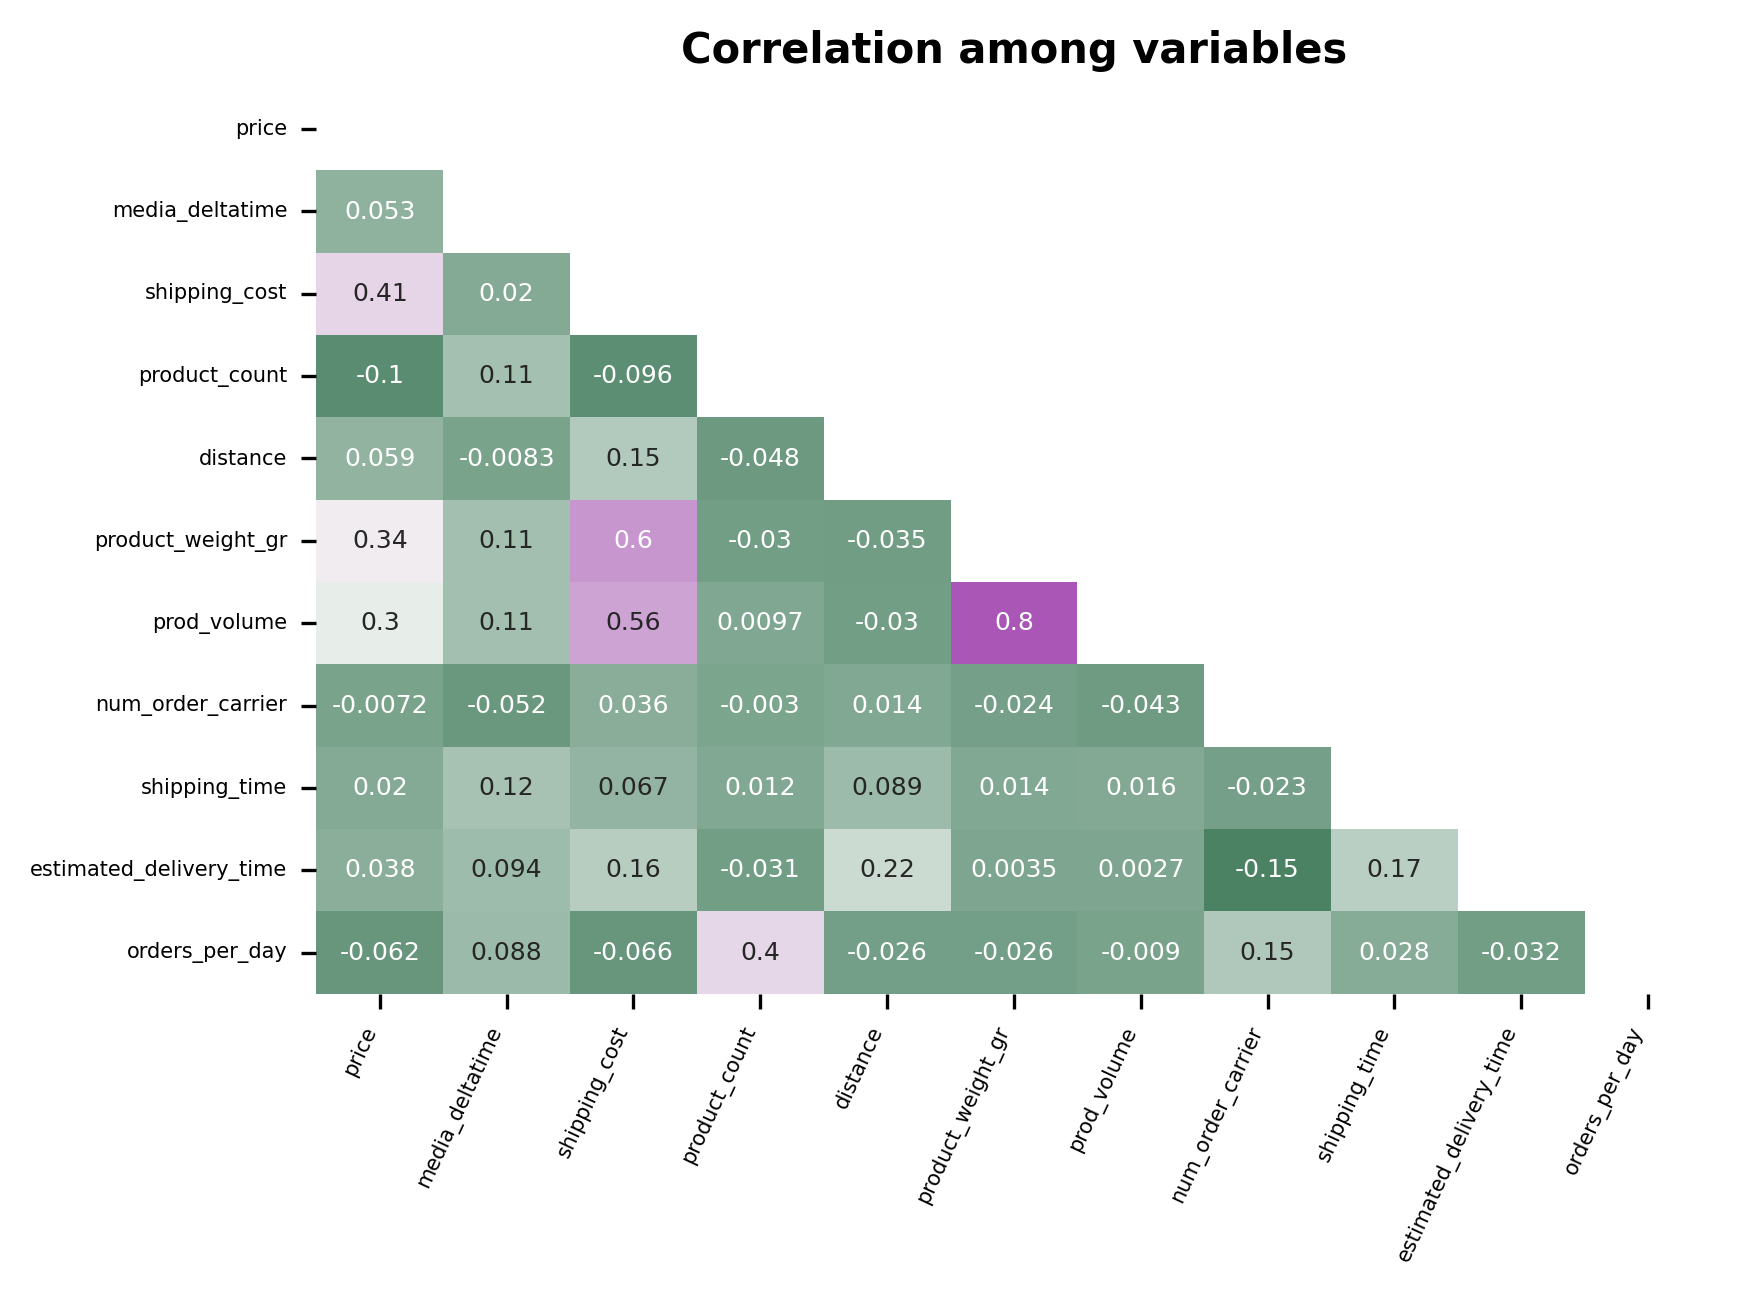

In [24]:
corr = df_delivery.corr()
matrix = np.triu(corr)

plt.figure(dpi = 300)
hm = sns.heatmap(corr,
            cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True),
            cbar = False,
            annot = True, annot_kws={"size": 6},
           mask = matrix)
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 5)
hm.set_yticklabels(hm.get_xmajorticklabels(), fontsize = 5)
hm.set_xticklabels(hm.get_xticklabels(), rotation=65, horizontalalignment='right')

plt.title('Correlation among variables', fontweight="bold", fontsize = 10)
plt.show()

## MODELS

When developing a machine learning project, it is a common practice to set a starting point. In this case, the baseline against which to compare the models is the error made by the estimated delivery time when the purchase is made. As it is shown below, the Mean Absolute Error is 14.78 and the Root Mean Squared Error is 16.48.

Therefore, the goal is to build a model that reaches a lower error.

In [25]:
mae_bl = mean_absolute_error(df_delivery['shipping_time'],df_delivery['estimated_delivery_time'])
print('MAE = ' + str(mae_bl))

rmse_bl = math.sqrt(mean_squared_error(df_delivery['shipping_time'],df_delivery['estimated_delivery_time']))
print('RMSE = ' + str(rmse_bl))

MAE = 14.7749165922654
RMSE = 16.478873246507504


To build the model, the dependent and the independent variables have to be set. After several tests of combinations of independent variables, the set of variables that lead to better performance are the following: ['product_weight_gr', 'media_deltatime', 'shipping_cost', 'distance', 'orders_per_day'].

Of course, variables were also selected on the basis of their meaning. Therefore, variables such as the estimated shipping time or the time that the package is in the hands of the seller have not been included in the model as they are strongly correlated to the dependent variable.

After having set the predictors, the dataset is split into training data and test data and then the feature are scaled so that all of them can be uniformly evaluated.

In [26]:
#setting dependent and independent variables
y = df_delivery.loc[:, ["shipping_time"]]
X = df_delivery.loc[:, ['product_weight_gr', 'media_deltatime', 'shipping_cost', 'distance', 'orders_per_day']]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

#feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Poisson Regression

Since we're predicting a count variable, a good model to start with is the Poisson Regression.
After the model is fitted on the training data, it is used to predict the test data and it does so with a Mean Absolute Erron = 3.52 and a Root Mean Squared Error = 4.29.

In [27]:
pr = PoissonRegressor()
pr.fit(X_train, y_train.values.ravel())
y_pred_pr = pr.predict(X_test)

mae_pr = mean_absolute_error(y_test,y_pred_pr)
print('MAE = ' + str(mae_pr))

rmse_pr = math.sqrt(mean_squared_error(y_test,y_pred_pr))
print('RMSE = ' + str(rmse_pr))

MAE = 1.6955235822947528
RMSE = 1.962314605589905


## K-Nearest Neighbors Regression

The second model that is tested is the K-Nearest Neighbors Regression model. The number of neighbors are set basing on the rule of thumb according to which it should be approxumately equal to the square root of the sample size.

Its perfomance metrics are printed below.

In [29]:
knr_model = KNeighborsRegressor(n_neighbors=200)
knr_model.fit(X_train, y_train.values.ravel())
y_pred_knr =knr_model.predict(X_test)

mae_KNR = mean_absolute_error(y_test,y_pred_knr)
print('MAE = ' + str(mae_KNR))

rmse_KNR = math.sqrt(mean_squared_error(y_test,y_pred_knr))
print('RMSE = ' + str(rmse_KNR))

MAE = 1.6740796428990956
RMSE = 1.945162440216761


## Support Vector Regression

Afterwards, the Support Vector Regression model is trained and tested using the radial basis function as kernel and a regularization parameter (C) = 3. 

In [30]:
svr_model = SVR(kernel = 'rbf', C = 3)
svr_model.fit(X_train, y_train.values.ravel())
y_pred_svr = svr_model.predict(X_test)

mae_SVR = mean_absolute_error(y_test,y_pred_svr)
print('MAE = ' + str(mae_SVR))

rmse_SVR = math.sqrt(mean_squared_error(y_test,y_pred_svr))
print('RMSE = ' + str(rmse_SVR))

MAE = 1.6647876399022066
RMSE = 1.9677205965625753


## Random Forest Regression

The next model that is built is the Random Forest Regression. It is tuned using the Grid Search algorithm.

#### TUNING

In [ ]:
'''
# Number of trees in random forest
n_estimators = [5,20,50,100, 200, 500, 1000, 1200, 1500, 1700, 2000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
parameters = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(random_state=0)
CV_rf= GridSearchCV(estimator=rf, param_grid=parameters, cv=5)
CV_rf.fit(X_train, y_train)
print(CV_rf.best_params_)
'''

In [31]:
# model
rf = RandomForestRegressor(n_estimators = 1000,
                           min_samples_split = 20,
                           min_samples_leaf = 3,
                           max_features='auto',
                           max_depth = 16,
                           bootstrap = True,
                           random_state=0)
rf.fit(X_train, y_train.values.ravel())
y_pred_rfr = rf.predict(X_test)

The following cell prints the model's Mean Absolute Erron and Root Mean Squared Error.

In [32]:
mae_rfr = mean_absolute_error(y_test,y_pred_rfr)
print('MAE = ' + str(mae_rfr))

rmse_rfr = math.sqrt(mean_squared_error(y_test,y_pred_rfr))
print('RMSE = ' + str(rmse_rfr))

MAE = 1.607691902247216
RMSE = 1.8935177522197664


It is interesting to understand how the Random Forest algorithm evaluates the importance of features. To do that, it is possible to use the scikit-learn’s built-in ”feature importances ” function. 
The importance of each feature is then sorted and represented by a barplot.

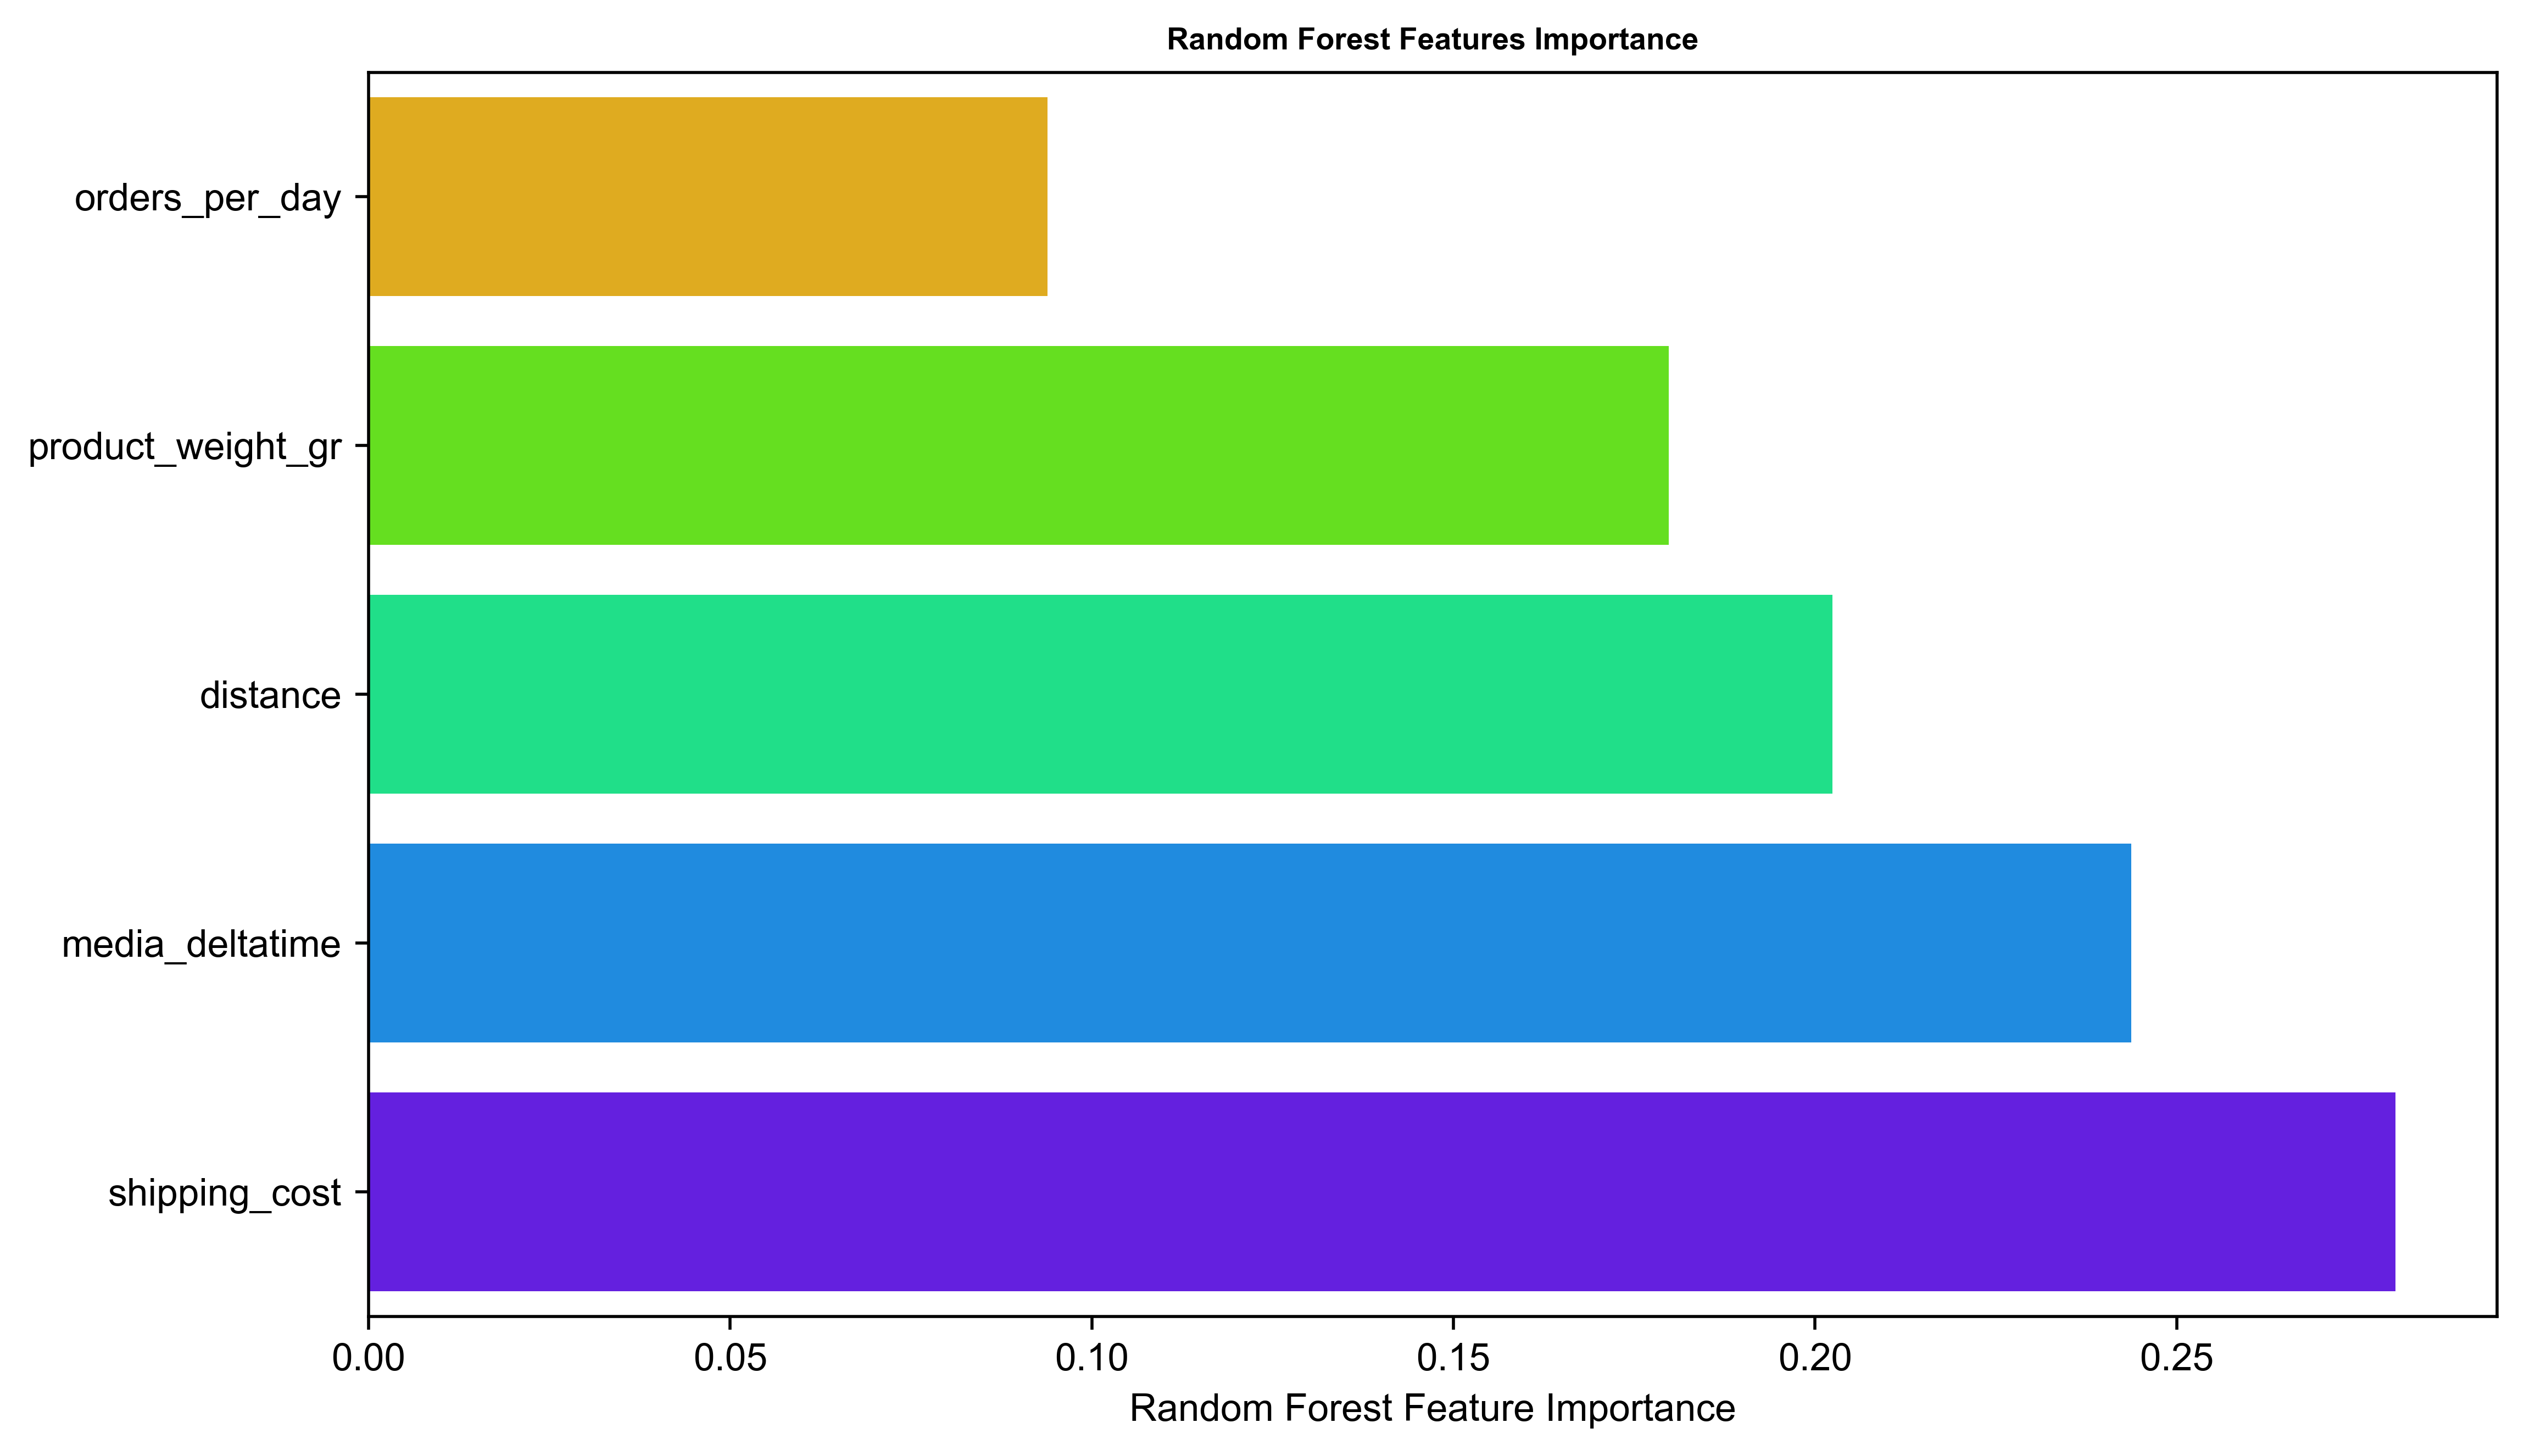

In [33]:
rf.feature_importances_
sorted_idx = rf.feature_importances_.argsort()
yaxis1 = pd.DataFrame(X)


plt.figure(figsize=(10, 6))
sns.barplot(x=rf.feature_importances_[sorted_idx], y=yaxis1.columns[sorted_idx], orient="h",
            palette="gist_rainbow")
plt.xlabel("Random Forest Feature Importance")
plt.title("Random Forest Features Importance", fontweight="bold", fontsize=8)
sns.set(font_scale=0.5)
plt.rcParams['figure.dpi'] = 500
plt.show()


## Gradient Boosting Regressor

The fifth model that is used is the Gradient Boosting Regressor, which was manually tuned.

In [43]:
gbr = GradientBoostingRegressor(n_estimators = 1000,
                                max_depth = 7,
                                learning_rate = 0.7,
                                loss = 'absolute_error',
                                min_samples_split = 20,
                                max_features = 'auto')
gbr.fit(X_train, y_train.values.ravel())
y_pred_gbr = gbr.predict(X_test)

In [44]:
mae_gbr = mean_absolute_error(y_test,y_pred_gbr)
print('MAE = ' + str(mae_gbr))


rmse_gbr = math.sqrt(mean_squared_error(y_test,y_pred_gbr))
print('RMSE = ' + str(rmse_gbr))

MAE = 1.6360285566172001
RMSE = 1.9841783208003971


## Artificial Neural Network

Lastly, an Artificial Neural Network was build by tuning it manually. 
It has 6 hidden layers and 1024 neurons for the first hidden layer. Their activation function is the Rectified Linear Unit funciton, while the one for the output layer is the Linear function.
The entire dataset is passed forward and backward through the neural network 30 times.

In [40]:
model = Sequential([
    Dense(1024, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(512, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(256, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(128, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(64, kernel_initializer='normal', activation='relu'),
    Dense(32, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')])

mae = MeanAbsoluteError()
model.compile(loss=mae,
              optimizer=Adam(learning_rate=0.1),
              metrics=[mae])

model.fit(X_train,
          y_train,
          epochs=30,
          batch_size=64,
          validation_split=0.2)


y_pred_ann = model.predict(X_test)


Epoch 1/30
426/426 [==============================] - 5s 8ms/step - loss: 24.6383 - mean_absolute_error: 24.6173 - val_loss: 1.7303 - val_mean_absolute_error: 1.7305
Epoch 2/30
426/426 [==============================] - 2s 5ms/step - loss: 1.7206 - mean_absolute_error: 1.7206 - val_loss: 1.7286 - val_mean_absolute_error: 1.7286
Epoch 3/30
426/426 [==============================] - 2s 5ms/step - loss: 1.7206 - mean_absolute_error: 1.7209 - val_loss: 1.7275 - val_mean_absolute_error: 1.7276
Epoch 4/30
426/426 [==============================] - 2s 6ms/step - loss: 1.7205 - mean_absolute_error: 1.7206 - val_loss: 1.7334 - val_mean_absolute_error: 1.7336
Epoch 5/30
426/426 [==============================] - 3s 6ms/step - loss: 1.7227 - mean_absolute_error: 1.7232 - val_loss: 1.7301 - val_mean_absolute_error: 1.7302
Epoch 6/30
426/426 [==============================] - 2s 5ms/step - loss: 1.7217 - mean_absolute_error: 1.7217 - val_loss: 1.7299 - val_mean_absolute_error: 1.7300
Epoch 7/30
426

As done for the previous models, the Mean Absolute Erron and Root Mean Squared Error are computed.

In [42]:
mae_ann = mean_absolute_error(y_test,y_pred_ann)
print('MAE = ' + str(mae_ann))

rmse_ann = math.sqrt(mean_squared_error(y_test,y_pred_ann))
print('RMSE = ' + str(rmse_ann))

MAE = 1.729528335711097
RMSE = 2.067501565796367


## Comparing models' performances

The bar graph below presents the performance metrics of the three algorithms used in the present project.
It is possible to see that the best performing algorithm in the considered metrics is the the Random Forest, with a Mean Absolute Erron = 1.60 and a Root Mean Squared Error = 1.89.

Therefore, the predictive performance compared to our baseline (which has a MAE = 14.77 and a RMSE = 16.48) was greatly improved.

In [35]:
models=['Poisson Regression', 'K-Nearest Neighbors Regression', 'Support Vector Regression', 'Random Forest Regressor', 'Gradient Boosting Regressor', 'Artificial Neural Network']

fig = go.Figure(data=[
    go.Bar(name='MAE', x=models, y=[1.70, 1.67, 1.66, 1.60, 1.64, 1.73], marker_color='Rebeccapurple',width=0.2),
    go.Bar(name='RMSE', x=models, y=[1.96, 1.95, 1.97, 1.89, 1.98, 2.07], marker_color='MediumPurple',width=0.2)
], layout={'title': "Models' Performance Metrics"})
fig.update_layout(barmode='group', bargap=0.55,bargroupgap=0.5)


fig.show()